<a href="https://colab.research.google.com/github/giuffridait/examples/blob/master/model_evaluation_aws.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score, precision_recall_fscore_support as score
from google.colab import files
import io

Loading base file extracted from AWS Athena

In [ ]:
uploaded = files.upload()

Saving af6efac5-2472-453d-ba0b-f3843ea5724c.csv to af6efac5-2472-453d-ba0b-f3843ea5724c (3).csv


In [ ]:
df = pd.read_csv(io.BytesIO(uploaded['af6efac5-2472-453d-ba0b-f3843ea5724c.csv']))

In [ ]:
print(df)

                       id   emotion             tweetid sentiment
0      477361527482114048   Neutral  477361527482114048   NEUTRAL
1      477369261598339072  Positive  477369261598339072  POSITIVE
2      477360654815621120   Neutral  477360654815621120  POSITIVE
3      477348890702647296   Neutral  477348890702647296   NEUTRAL
4      477344394849562624   Neutral  477344394849562624  NEGATIVE
...                   ...       ...                 ...       ...
71897  477360933560672257   Neutral  477360933560672257   NEUTRAL
71898  477368039411687424   Neutral  477368039411687424   NEUTRAL
71899  477369566591717376  Positive  477369566591717376   NEUTRAL
71900  477377088258068480   Neutral  477377088258068480   NEUTRAL
71901  477378056580263936   Neutral  477378056580263936   NEUTRAL

[71902 rows x 4 columns]


Harmonising the labels







In [ ]:
df['emotion'] =  df['emotion'].str.upper()

Removing labels not present on both datasets

In [ ]:
df2 = df[df["sentiment"].str.contains("MIXED|NULL")==False]
print(df2)


                       id   emotion             tweetid sentiment
0      477361527482114048   NEUTRAL  477361527482114048   NEUTRAL
1      477369261598339072  POSITIVE  477369261598339072  POSITIVE
2      477360654815621120   NEUTRAL  477360654815621120  POSITIVE
3      477348890702647296   NEUTRAL  477348890702647296   NEUTRAL
4      477344394849562624   NEUTRAL  477344394849562624  NEGATIVE
...                   ...       ...                 ...       ...
71897  477360933560672257   NEUTRAL  477360933560672257   NEUTRAL
71898  477368039411687424   NEUTRAL  477368039411687424   NEUTRAL
71899  477369566591717376  POSITIVE  477369566591717376   NEUTRAL
71900  477377088258068480   NEUTRAL  477377088258068480   NEUTRAL
71901  477378056580263936   NEUTRAL  477378056580263936   NEUTRAL

[69898 rows x 4 columns]


Checking present labels

In [ ]:
print(df2['emotion'].value_counts())
print(df2['sentiment'].value_counts())

NEUTRAL     39919
POSITIVE    17382
NEGATIVE    12597
Name: emotion, dtype: int64
NEUTRAL     52433
POSITIVE    11357
NEGATIVE     6108
Name: sentiment, dtype: int64


**y_true** is set by the manual labelled emotion from base dataset, **y_pred** the AWS comprehend output. Labels are used to exclude 'Mixed' and 'nulls' which arent common to both datasets. 

In [ ]:
y_true = df2['emotion']
y_pred = df2['sentiment']

labels=['NEUTRAL', 'POSITIVE', 'NEGATIVE']

In [ ]:
cnf_matrix = confusion_matrix(y_true, y_pred, labels)

Raw confusion matrix result.

In [ ]:
print(cnf_matrix)

[[34646  3708  1565]
 [ 9737  6957   688]
 [ 8050   692  3855]]


Setting the confusion matrix graph without normalization

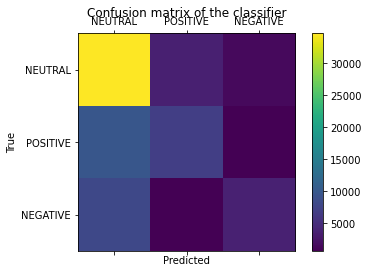

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cnf_matrix)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Setting the confusion matrix with normalization using sklearn native function

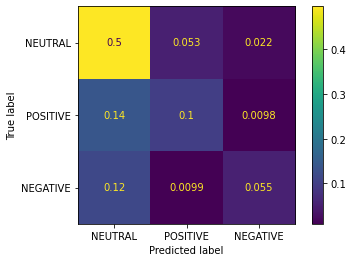

In [ ]:
cm = confusion_matrix(y_true, y_pred, labels, normalize='all')
cmd = ConfusionMatrixDisplay(cm, display_labels=['NEUTRAL', 'POSITIVE', 'NEGATIVE'])
cmd.plot()

In multilabel classification, this function computes subset accuracy: the set of labels predicted for a sample must exactly match the corresponding set of labels in y_true.

The best performance is 1 with `normalize == True` and the number of samples with `normalize == False`.


In [ ]:
print("{:.0%}".format(accuracy_score(y_true, y_pred, normalize=True)))#returns the fraction of correctly classified samples
print(accuracy_score(y_true, y_pred, normalize=False)) 


65%
45458


`Precision` is the ability of the classifier not to label as positive a sample that is negative, and `recall` is the ability of the classifier to find all the positive samples.
The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0.
The formula for the F1 score here given by:

`F1 = 2 * (precision * recall) / (precision + recall)`

`Support` is the number of occurrences of each label in y_true.



In [ ]:
print(classification_report(y_true, y_pred, target_names=labels))


              precision    recall  f1-score   support

     NEUTRAL       0.63      0.31      0.41     12597
    POSITIVE       0.66      0.87      0.75     39919
    NEGATIVE       0.61      0.40      0.48     17382

    accuracy                           0.65     69898
   macro avg       0.63      0.52      0.55     69898
weighted avg       0.64      0.65      0.62     69898



Calculate metrics globally by counting the total true positives, false negatives and false positives.


In [ ]:
print(precision_recall_fscore_support(y_true, y_pred, average='micro', labels=labels))

(0.6503476494320295, 0.6503476494320295, 0.6503476494320295, None)


Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.



In [ ]:
print(precision_recall_fscore_support(y_true, y_pred, average='macro', labels=labels))

(0.634826768810432, 0.524724795363548, 0.5488809665265552, None)


Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall.



In [ ]:
print(precision_recall_fscore_support(y_true, y_pred, average='weighted', labels=labels))

(0.6434430424501628, 0.6503476494320295, 0.6231824121236492, None)


In [ ]:
precision_recall_fscore_support(y_true, y_pred, average=None, labels=labels)


(array([0.66076707, 0.61257374, 0.63113949]),
 array([0.86790751, 0.40024163, 0.30602524]),
 array([0.75030319, 0.48415046, 0.41218925]),
 array([39919, 17382, 12597]))